In [104]:
import numpy as np
from sklearn import datasets
import torch
import torch.nn as nn
import torch.optim as optim
import torchbnn as bnn
import matplotlib.pyplot as plt
from src.features import build_features as f
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, log_loss


%matplotlib inline

In [54]:
vladdy = 665489
soto = 665742
schneider = 676914
biggio = 624415
showtime = 660271
batter = vladdy

X_train, y_train, X_test, y_test, encoders = f.get_pitch_outcome_dataset_xgb(batter, split=True)

In [105]:
from src.data.data_utils import query_mlb_db
batter_id = vladdy
data = query_mlb_db(f'''
select 
            case
                when description='swinging_strike' or description='swinging_strike_blocked' or description='called_strike' or description='foul_tip' 
                    or description='swinging_pitchout' then 'strike'
                when description='foul' or description='foul_pitchout' then 'foul'
                when description='ball' or description='blocked_ball' or description='pitchout' then 'ball'
                when description='hit_by_pitch' then 'hit_by_pitch'
                when description='hit_into_play' then 'hit_into_play'
                else NULL
            end as pitch_outcome,
            
            pitch_number, strikes, balls,
            
            release_speed, 
            release_spin_rate, 
            release_extension,

            release_pos_x,
            release_pos_y,
            release_pos_z,
            
            spin_axis,
            pfx_x, pfx_z, 
            
            vx0, vy0, vz0,
            ax, ay, az,
            plate_x, plate_z
            
        from Statcast
        where batter={batter_id}
        /* and game_pk in (
                select distinct game_pk
                from Statcast
                where batter = {batter_id}
                order by game_date desc
                limit 324
        ) */
        and pitch_outcome & p_throws & pitch_number & strikes & balls &
            release_speed &
            release_spin_rate &
            release_extension &

            release_pos_x &
            release_pos_y &
            release_pos_z &
            
            spin_axis &
            pfx_x & pfx_z &
            
            vx0 & vy0 & vz0 &
            ax & ay & az &
            plate_x & plate_z
        is not null
        order by game_date asc, at_bat_number asc, pitch_number asc;
''')



In [108]:
# Define features and target
features = data.drop(columns=['pitch_outcome'])
target = data['pitch_outcome']


label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(target)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(features, y_encoded, test_size=0.2, shuffle=False)

In [110]:
y_train

array([0, 1, 4, ..., 3, 4, 3])

In [111]:
# Preprocessing pipeline
numeric_features = features.select_dtypes(include=['float64', 'int64']).columns
categorical_features = features.select_dtypes(include=['object']).columns

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])

import xgboost as xgb
from sklearn.metrics import classification_report, log_loss

# Train the model
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', xgb.XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric='mlogloss'))
])

# Train the model
model.fit(X_train, y_train)

# Evaluate the model
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)

print(classification_report(y_test, y_pred))
print('Log Loss:', log_loss(y_test, y_prob))

              precision    recall  f1-score   support

           0       0.79      0.86      0.83       894
           1       0.41      0.27      0.33       412
           2       0.40      0.40      0.40         5
           3       0.45      0.49      0.47       455
           4       0.49      0.49      0.49       583

    accuracy                           0.60      2349
   macro avg       0.51      0.50      0.50      2349
weighted avg       0.58      0.60      0.59      2349

Log Loss: 0.9303840079806969


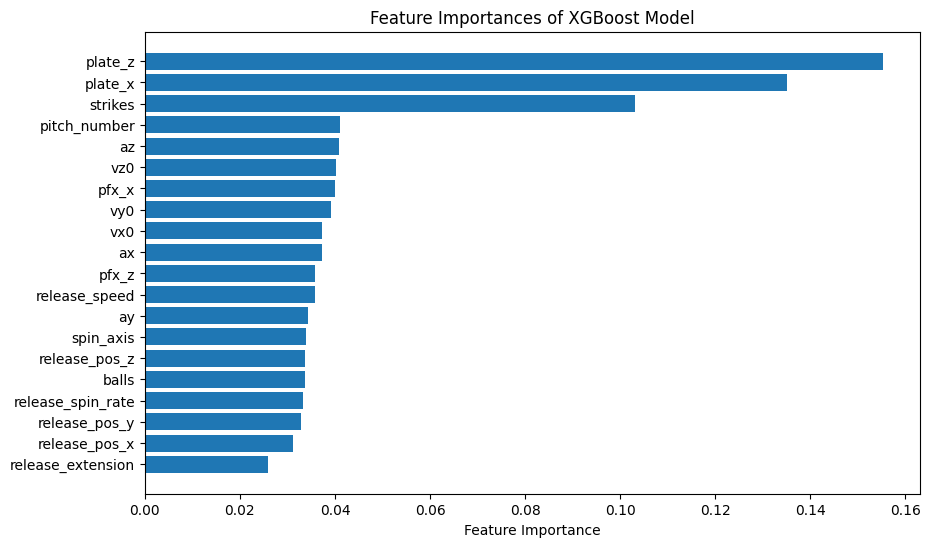

Log Likelihood (Log Loss): 0.9303840079806969


In [119]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import log_loss

# Extract the trained XGBoost model from the pipeline
xgb_model = model.named_steps['classifier']

# Get feature names after preprocessing
#nehot_categories = model.named_steps['preprocessor'].named_transformers_['cat'].categories_

#print(onehot_categories)
#onehot_feature_names = np.concatenate(onehot_categories)
#feature_names = np.concatenate([numeric_features, onehot_feature_names])
feature_names = numeric_features

# Plot feature importances
importance = xgb_model.feature_importances_
sorted_idx = np.argsort(importance)

plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_idx)), importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), feature_names[sorted_idx])
plt.xlabel('Feature Importance')
plt.title('Feature Importances of XGBoost Model')
plt.show()

# Compute log likelihood (log loss)
y_prob = model.predict_proba(X_test)
log_likelihood = log_loss(y_test, y_prob)

print('Log Likelihood (Log Loss):', log_likelihood)


In [122]:
pd.DataFrame(y_train).value_counts()

0
0    3535
4    2428
3    1865
1    1544
2      22
Name: count, dtype: int64